In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import pathlib
import sys

home = pathlib.Path().resolve().parent
path = str(pathlib.Path(home, r'Andrey'))
sys.path.insert(0, home)

from src.mixture_fit import gen_data, fits, fits_ls, sum_exp_curv, fit, sum_exp, loss_function, right_order
from src.data_loading import load_data
from src.optimal_number import optimal_params
from src.log_data_analysis import log_estimate, bounds
from src.errors import bootstrap_resudial, bootstrap_residual
from src.bootstrapping import bootstrap, final_guess

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

%matplotlib widget

# Метрики
1. Стабильность.

Повторяемость получаемых результатов. Тестируется на наборе R2-5times + симуляции с различными погрешностями.

2. Чувствительность/разрешающая способность.

Способность различать две (или более) компоненты смеси при их наличии.

Тестируется на наборах R2-R4 (worst case), R1-R2-x-*-*-new.txt, R2-R5-*-*-new.txt + симуляции с разным подбором коэффициентов самодиффузии и содержания компонент.

3. Точность.

Погрешность определения данных параметров смеси. Тестируется на симуляции с добавлением погрешностей, рассчитанных для R2-5times и DOSY-R2-1-4-DMSO-5points-1000raz-integrals.txt

### Стабильность

In [36]:
def stability(fun: callable, mode='simulate', bs_num=100, comp_num=1, log=True, *args, **kwargs):
    if mode == 'simulate':
        if comp_num > 4:
            raise ValueError('Current state of method only supports simmulation for up to 4 components')
        D_coeff = np.array([1.042, 0.306, 0.694, 0.463])[:comp_num]
        w_coeff = 1 / comp_num

        parameters = np.zeros(2 * comp_num)
        parameters[1::2] = D_coeff
        parameters[::2] = w_coeff
        folder = pathlib.Path(path,'data', 'R2_5times')
        data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-1.txt')
        x, _ = load_data(data_path)
        y_model = sum_exp(parameters, x)

        res, res_std, guessed_count = [], [], []
        sigma_range = np.geomspace(2e-3, 2e-1, 15)
        for sigma in sigma_range:
            print(f'Processing sigma = {sigma:.2E}')
            result, optim_res = bootstrap(fun, x, y_model, sigma, bs_num, *args, **kwargs)
            correct_guess = (optim_res[:, 0] == comp_num-1)
            if correct_guess.sum() == 0:
                correct_mean = np.zeros(comp_num * 2)
                correct_std = np.zeros(comp_num * 2)
            else:
                stacked_res = np.vstack(optim_res[:, 1][correct_guess])
                correct_mean = stacked_res.mean(0)
                correct_std = stacked_res.std(0)
            guessed_count.append(correct_guess.sum())
            res.append(correct_mean)
            res_std.append(correct_std)
        
        guessed_count = np.array(guessed_count)
        res = np.vstack(res)
        res_std = np.vstack(res_std)

        if log:
            plt.close('all')
            plt.subplot(1, 3, 1)
            plt.plot(sigma_range, guessed_count)
            plt.ylim(-bs_num*0.05, 1.05*bs_num)
            plt.xscale('log')
            for i in range(comp_num):
                plt.subplot(comp_num, 3, 2 + 3 * i)
                plt.xscale('log')
                plt.hlines(parameters[2 * i], sigma_range[0], sigma_range[-1])
                plt.errorbar(sigma_range, res[:, 2 * i], res_std[:, 2 * i], fmt='.')
                
                plt.subplot(comp_num, 3, 3 + 3 * i)
                plt.xscale('log')
                plt.hlines(parameters[2 * i + 1], sigma_range[0], sigma_range[-1])
                plt.errorbar(sigma_range, res[:, 2 * i+1], res_std[:, 2 * i+1], fmt='.')
            
            plt.show()
        
        return sigma_range, guessed_count, res, res_std

    elif mode == 'real':
        results = []
        y_arr = [] 
        for i in range(5):
            folder = pathlib.Path(path,'data', 'R2_5times')
            data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-{i + 1}.txt')
            x, y = load_data(data_path)
            y_arr.append(y)

            res = fun(x, y, *args, **kwargs)
            results.append(res)
        y_arr = np.vstack(y_arr)
        sigma = y_arr.std(0)
        sigma[0] = sigma[1]
        results = np.vstack(results)
        results_std = ((results - results.mean(0)) ** 2).mean(0) ** 0.5
        
        guesses = []
        correct_idx = []
        for i in range(5):
            guess = final_guess(x, y, sigma, results[i], results_std)
            guesses.append(guess)
            if guess[0] == 0:
                correct_idx.append(i)
            if log:
                print(f'Guessed number of components = {guess[0] + 1}, params = {guess[1]}')
        guesses = np.array(guesses)
        if log:
            print(f'Correctly guesses {len(correct_idx)}/5')
            stacked = np.vstack(guesses[correct_idx])
            stacked_mean = stacked[:, 1].mean(0)
            stacked_std = ((stacked[:, 1] - stacked_mean.reshape(-1, 1)) ** 2).mean() ** 0.5
            print(f'w = {stacked_mean[0]:.4f} ± {stacked_std[0]:.4f}')
            print(f'D = {stacked_mean[1]:.4f} ± {stacked_std[1]:.4f}')   
        return results, guesses
            
    else:
        raise ValueError('Mode must be "simulate" or "real"!')

In [33]:
# sigma_range, guessed_count, res, res_std = stability(fits, comp_num=3, bs_num=100, log=True, method='L-BFGS-B', reg=0.05)
# sigma_range, guessed_count, res, res_std = stability(fits_ls, comp_num=2, bs_num=100, log=True)
res_real, guess = stability(fits_ls, mode='real')

Guessed number of components = 1, params = [0.99279708 1.11163779]
Guessed number of components = 2, params = [0.50928806 1.10719319 0.50928806 1.1071932 ]
Guessed number of components = 1, params = [0.9954679  1.10893701]
Guessed number of components = 1, params = [0.9982102  1.11814195]
Guessed number of components = 1, params = [0.99715746 1.13485381]
Correctly guesses 4/5
w = 0.9959 ± 0.0866
D = 1.1184 ± 0.0872


Processing sigma = 2.00E-03


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 2.78E-03


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 3.86E-03


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 5.37E-03


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 7.46E-03


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 1.04E-02


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 1.44E-02


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 2.00E-02


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 2.78E-02


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 3.86E-02


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 5.37E-02


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 7.46E-02


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 1.04E-01


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 1.44E-01


  0%|          | 0/100 [00:00<?, ?it/s]

Processing sigma = 2.00E-01


  0%|          | 0/100 [00:00<?, ?it/s]

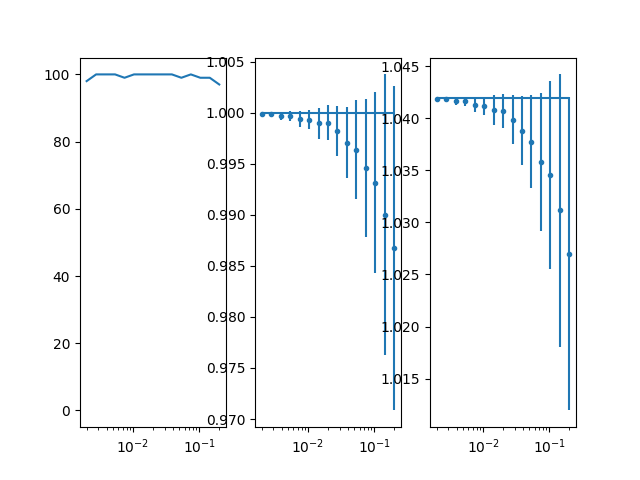

In [37]:
sigma_range, guessed_count, res, res_std = stability(fits, comp_num=1, bs_num=100, log=True, method='L-BFGS-B', reg=0.05)
# sigma_range, guessed_count, res, res_std = stability(fits_ls, comp_num=2, bs_num=50, log=True, solver='exact')

### Разрешающая способность

In [126]:
def resolution(function: callable, *args, **kwargs):
    func = lambda x, y: function(x, y, *args, **kwargs)
    
    folder = pathlib.Path(path,'data', 'R1-R2')
    data_path = pathlib.Path(folder, f'R1-R2-1-5-new.txt')
    x, y = load_data(data_path)
    params = func(x, y)
    
    optimal_output = optimal_params(x, y, params)

    # print('CALCULATING ERROR PLOT')
    # err_array = np.linspace(1e-3, 0.25, 50)
    # art_mean = np.zeros((len(err_array),2))
    # art_std = np.zeros((len(err_array),2))
    # for idx, err in tqdm(enumerate(err_array), total=len(err_array)):
    #     art_set = _stability(function, real_data=False,
    #                         params=params_mean[0], err=err, *args, **kwargs)
    #     curr_art_mean = art_set.mean(0)
    #     curr_art_std = ((art_set - curr_art_mean) ** 2).mean(0) ** 0.5
    #     art_mean[idx] = curr_art_mean[0]
    #     art_std[idx] = curr_art_std[0]
    
    # plt.close('all')
    # plt.figure(figsize=(12, 5))
    # plt.subplot(1,2,1)
    # plt.title('w value')
    # plt.plot(err_array, art_mean[:,0])
    # plt.fill_between(err_array, art_mean[:,0]-art_std[:,0], art_mean[:,0]+art_std[:,0], alpha=0.2)
    # plt.subplot(1,2,2)
    # plt.title('D value')
    # plt.plot(err_array, art_mean[:,1])
    # plt.fill_between(err_array, art_mean[:,1]-art_std[:,1], art_mean[:,1]+art_std[:,1], alpha=0.2)
    # plt.show()

    return params, optimal_output

In [127]:
resolution(fits_linsqr, solver='exact')

([array([0.96138946, 0.79009411]),
  array([0.20685028, 0.35876391, 0.79798729, 1.07460789]),
  array([0.17924528, 0.33378813, 0.81750565, 1.03995514, 0.01140963,
         5.70617933]),
  array([2.36733552e-02, 1.22528072e-01, 2.47754577e-01, 4.79953218e-01,
         7.30504103e-01, 1.10081122e+00, 6.54927903e-03, 9.66697258e+00]),
  array([2.38131253e-02, 1.23082471e-01, 2.47780843e-01, 4.80313981e-01,
         2.79513699e-01, 1.10086355e+00, 4.50825742e-01, 1.10089979e+00,
         6.54797333e-03, 9.66870196e+00])],
 (array([-1049.225648  , -1706.24557863, -1722.67315349, -1720.45813228,
         -1716.45813126]),
  array([5.79071588e-147, 2.70892788e-004, 1.00000000e+000, 3.30380385e-001,
         4.47121003e-002]),
  array([-1043.52158747, -1694.83745757, -1705.56097191, -1697.64189016,
         -1687.93782862]),
  array([1.73769787e-144, 4.69265308e-003, 1.00000000e+000, 1.90718687e-002,
         1.48998899e-004]),
  2,
  2,
  2))

In [128]:
resolution(fits, method='BFGS')

([array([0.96138964, 0.7900944 ]),
  array([0.20684293, 0.35875697, 0.79799428, 1.07460111]),
  array([0.17922534, 0.33376844, 0.81751994, 1.03993145, 0.01141524,
         5.70409152]),
  array([1.25733264e-01, 2.86133975e-01, 3.92129945e-01, 8.06570080e-01,
         4.83917651e-01, 1.18630076e+00, 6.55314303e-03, 8.68916830e+00]),
  array([ 0.09972043,  0.2521519 ,  0.63821672,  0.83318023,  0.32663954,
          1.58483989, -0.07439655,  2.76422795,  0.01836583,  6.51366223])],
 (array([-1049.225648  , -1706.24557772, -1722.67315001, -1720.25620303,
         -1717.0439614 ]),
  array([5.79072595e-147, 2.70893137e-004, 1.00000000e+000, 2.98652827e-001,
         5.99290265e-002]),
  array([-1043.52158747, -1694.83745667, -1705.56096843, -1697.43996091,
         -1688.52365876]),
  array([1.73770089e-144, 4.69265913e-003, 1.00000000e+000, 1.72403320e-002,
         1.99707885e-004]),
  2,
  2,
  2))